In [1]:
%matplotlib inline

from cosima_cookbook import build_index, get_nc_variable
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import joblib
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import IPython.display

netcdf_index loaded.


/home/156/al1353/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
memory = joblib.Memory(cachedir='.')

In [3]:
expts = ['gfdl_nyf_1080_cp','gfdl_nyf_1080_SH','gfdl_nyf_1080_PI','gfdl_nyf_1080_UP']

# Load data

In [4]:
u = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','u',n=10, time_units='days since 1900-01-01')

dzt = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','dzt',n=10, time_units='days since 1900-01-01')

yt_ocean = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','yt_ocean',n=10, time_units='days since 1900-01-01')

rho = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','pot_rho_2',n=10, time_units='days since 1900-01-01')

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

/home/156/al1353/cosima-cookbook/cosima_cookbook/netcdf_index.py:368: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

# 1.Change the coordinates of the u_t 

In [5]:
u_t = dzt.copy()*0.0
u_t.name = 'u_t'
u_t.load()
u_t[:,:,2:,2:] = 0.25*(u[:,:,1:,1:] + u[:,:,:-1,:-1] + u[:,:,1:,:-1] + u[:,:,:-1,1:]) #Just do the multiplication 
#between xt_ocean and yt_ocean

In [6]:
u_t[:,:,1:,1:].shape

(10, 50, 1079, 1439)

In [7]:
u[:,:,:-1,1:].shape

(10, 50, 1079, 1439)

# 2. Calculate the tx_trans

## 2.1 (uh)mean

In [8]:
a=u_t[0,0,:,:]*dzt[0,0,:,:] # a is doing the multipication for the last 2 dimensions: yt_ocean and xt_ocean

b=a[:,0]*yt_ocean # b is doing the multipication only for the yt_ocean dimension

c=dzt.copy()*0.0 # construct an empty xarray with shape of dzt

c.load() # load data

c[:,:,0,0]=u_t[:,:,0,0] # the first 2 arrays are the same as u_t

c[0,0,:,0]=b # the third array of c euqals b

c[0,0,0,:]=a[0,:] # The last array of c equals the last array of a

tx_trans = c # c is actually the tx_transport

## 2.2 u_mean*h_mean

In [32]:
utm = u_t.mean(dim='time')
dztm = dzt.mean(dim='time')

In [37]:
am=utm[0,:,:]*dztm[0,:,:] # a is doing the multipication for the last 2 dimensions: yt_ocean and xt_ocean

bm=am[:,0]*yt_ocean # b is doing the multipication only for the yt_ocean dimension

cm=utm.copy()*0.0 # construct an empty xarray with shape of dzt

cm.load() # load data

cm[:,0,0]=utm[:,0,0] # the first 2 arrays are the same as u_t

cm[0,:,0]=bm # the third array of c euqals b

cm[0,0,:]=am[0,:] # The last array of c equals the last array of a

txtrans_m = cm # c is actually the tx_transport

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [22]:
tx_trans[2,20,300,300]

<xarray.DataArray 'dzt' ()>
array(0.0)
Coordinates:
    yt_ocean  float64 -44.2
    xt_ocean  float64 -204.9
    st_ocean  float64 330.0
    time      object 2449-07-13T12:00:00
    geolat_t  float64 -44.2
    geolon_t  float64 -204.9

In [23]:
tx_trans

<xarray.DataArray 'dzt' (time: 10, st_ocean: 50, yt_ocean: 1080, xt_ocean: 1440)>
array([[[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]],


       ..., 
       [[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 -80.76 -80.65 -80.55 ...
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 -279.1 -278.9 -278.6 ...
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 35.36 45.58 55.85 66.26 ...
  * time      (time) object 2449-07-03T12:00:00 2449-07-08T12:00:00 ...
    geolat_t  (time, yt_ocean, xt_ocean) float64 -81.08 -81.08 -81.08 -81.08 ...
    geolon_t  (time, yt_ocean, xt_ocean) float64 -279.9 -279.6 -279.4 -279.1 ...

In [40]:
txtrans_m

<xarray.DataArray 'u_t' (st_ocean: 50, yt_ocean: 1080, xt_ocean: 1440)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 -80.76 -80.65 -80.55 ...
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 -279.1 -278.9 -278.6 ...
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 35.36 

# 3. Transport

In [9]:
@memory.cache
def calc_transport(expt):
    
    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .sum('st_ocean')  

    streamfunction = tx_trans_inz.cumsum('yt_ocean') # integrate in y direction

    streamfunction0 = streamfunction.sel(xu_ocean=20, yt_ocean=-10, method='nearest') # select somewhere
    # on the continent to be reference point 

    transport = - (streamfunction - streamfunction0) # To make the transport on the continent to be 0
    
    transport = transport.compute()
    
    return transport

# 4. AL

In [10]:
@memory.cache
def mask(expt):
    
    al_rho = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .mean(dim='time')\
                .compute()
    al_mask = (al_rho <= 1026.5)
    
    return al_mask

In [11]:
@memory.cache
def calc_altransport(expt):
    
    al_tx_trans = tx_trans\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .mean(dim='time')\
                .compute()
    
    return al_tx_trans

In [12]:
@memory.cache
def tdrho(expt):
    
    al_rho_2d = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .mean(dim='time')\
                .compute()
    
    return al_rho_2d

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


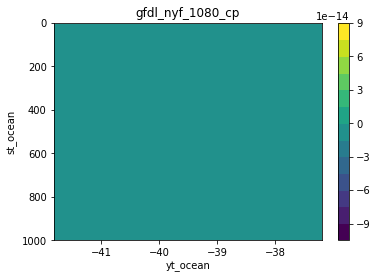

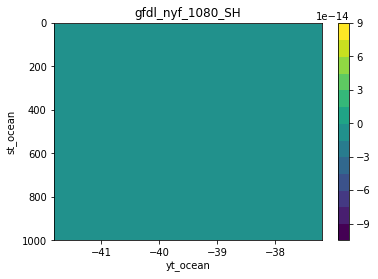

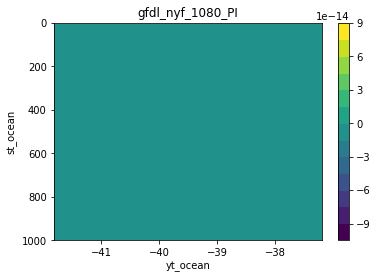

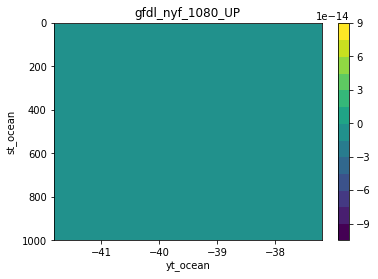

In [15]:
for expt in expts:
    
    al_mask_2d = mask(expt)
    al_tx_trans_2d = calc_altransport(expt)
    al_rho_2d = tdrho(expt)
    plt.figure()
    al_rho_2d.plot.contour(levels=[1026.5], colors='k')
    (al_tx_trans_2d * al_mask_2d).plot.contourf(levels=15)   
    plt.ylim(1000, 0)
    plt.title(expt)

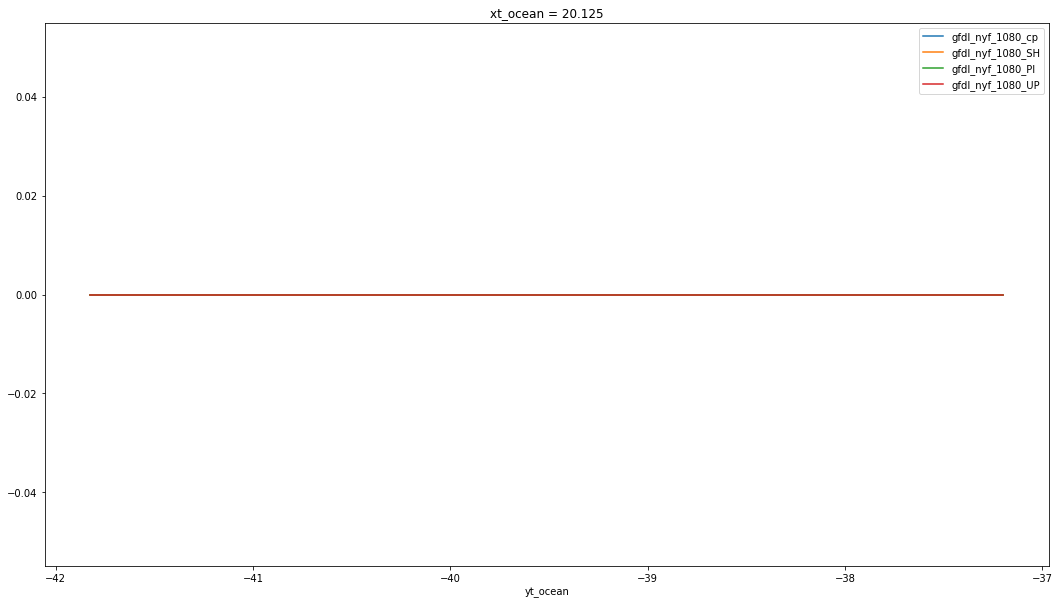

In [14]:
plt.figure(figsize=(18,10))
for expt in expts:
    temp = (calc_altransport(expt) * mask(expt)).cumsum('yt_ocean').sum('st_ocean')
    temp1 = temp - temp[-1]
    temp1.plot(label=expt)
plt.legend(loc=0)   

## u.mean*h.mean

In [ ]:
@memory.cache
def calc_altransport_m(expt):
    
    al_tx_trans_m = txtrans_m\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .mean(dim='time')\
                .compute()
    
    return al_tx_trans_m